<a href="https://colab.research.google.com/github/Michelleagl/Series_de_Tiempo/blob/main/AutoETS_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import yfinance as yf

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)



In [31]:
stock = 'META'
ticker = yf.Ticker(stock)
df = ticker.history(start= '2013-01-01', end= '2023-12-31', interval='1mo')['Close']

df

,Close
Date,
2013-01-01 00:00:00-05:00,30.887003
2013-02-01 00:00:00-05:00,27.168201
2013-03-01 00:00:00-05:00,25.503212
2013-04-01 00:00:00-04:00,27.686640
2013-05-01 00:00:00-04:00,24.276905
...,...
2023-08-01 00:00:00-04:00,295.001801
2023-09-01 00:00:00-04:00,299.308807
2023-10-01 00:00:00-04:00,300.365601


In [32]:
print(df.dtypes)


float64


In [33]:
df = df.reset_index()  # Reset the index to make 'Date' a regular column
df["ds"] = pd.to_datetime(df["Date"])  # Convert the 'Date' column to datetime and assign to 'ds'

In [34]:
!pip install statsforecast


In [35]:
df["unique_id"]="1"
# The DataFrame has 4 columns after adding 'ds' and 'unique_id' in previous steps, modify the column names accordingly
#df.columns=["ds", "y", "unique_id"] # incorrect
# assuming the first column is 'Date' based on previous cell outputs
df.columns = ['Date', 'Close', 'ds', 'unique_id'] # Assuming original columns and new ones
# or if you want to keep only specific columns:
# df = df[['ds', 'Close', 'unique_id']]  # Keep only 'ds', 'Close', and 'unique_id' columns
# df.columns = ["ds", "y", "unique_id"] # then rename them
df.head()

,Date,Close,ds,unique_id
0,2013-01-01 00:00:00-05:00,30.887003,2013-01-01 00:00:00-05:00,1
1,2013-02-01 00:00:00-05:00,27.168201,2013-02-01 00:00:00-05:00,1
2,2013-03-01 00:00:00-05:00,25.503212,2013-03-01 00:00:00-05:00,1
3,2013-04-01 00:00:00-04:00,27.686640,2013-04-01 00:00:00-04:00,1
4,2013-05-01 00:00:00-04:00,24.276905,2013-05-01 00:00:00-04:00,1


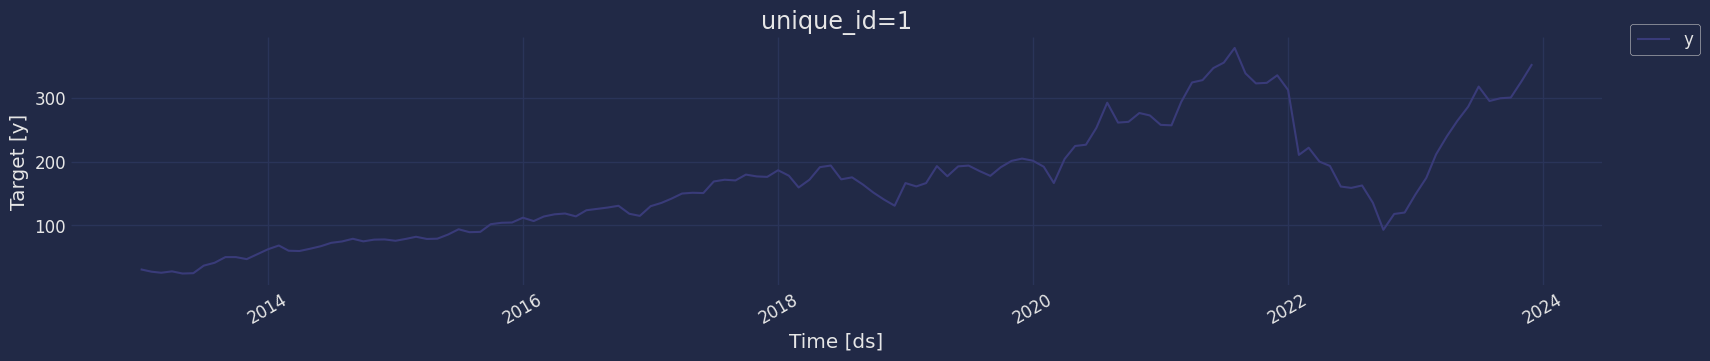

In [36]:
# Change 'Close' to 'y'
df = df.rename(columns={'Close': 'y'})

# Select only the required columns for StatsForecast.plot()
df_plot = df[['ds', 'y', 'unique_id']]

# Now plot using the modified DataFrame:
from statsforecast import StatsForecast
StatsForecast.plot(df_plot)

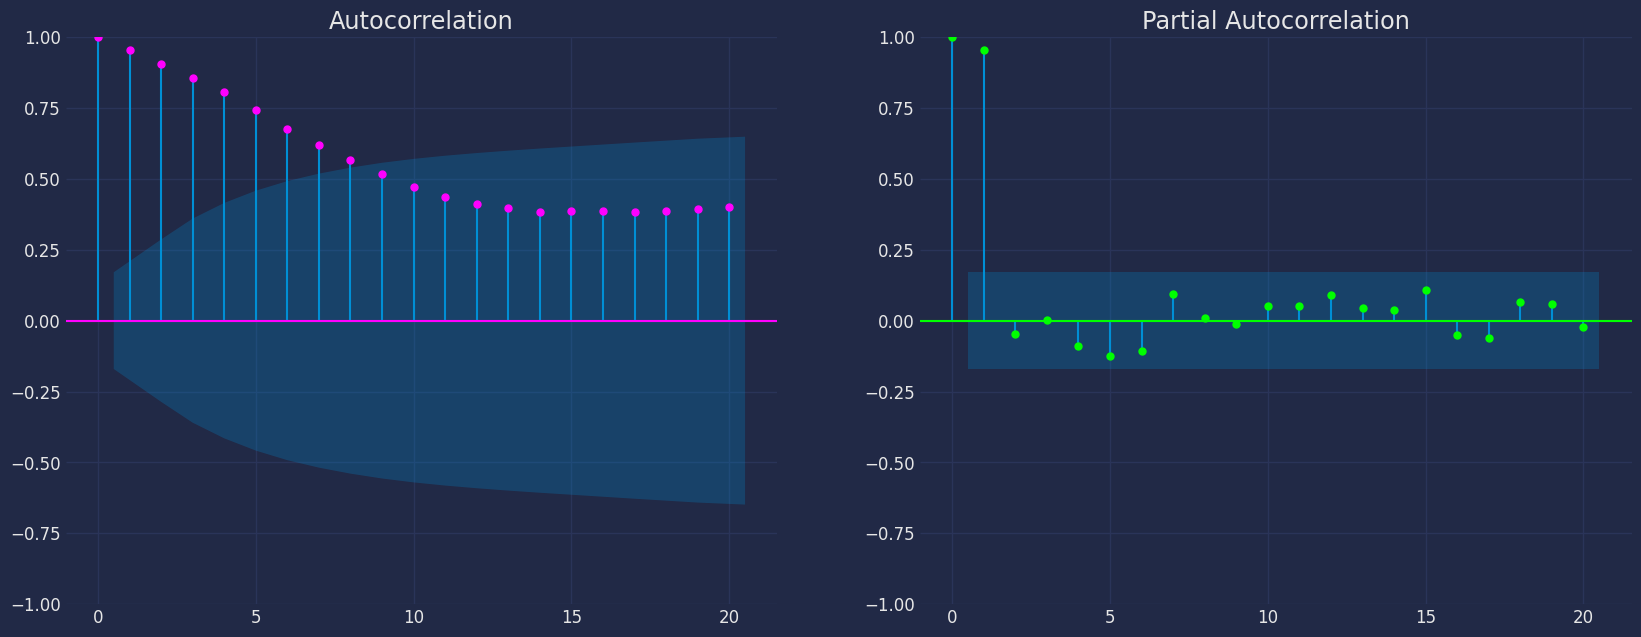

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=20, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Plot
plot_pacf(df["y"],  lags=20, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

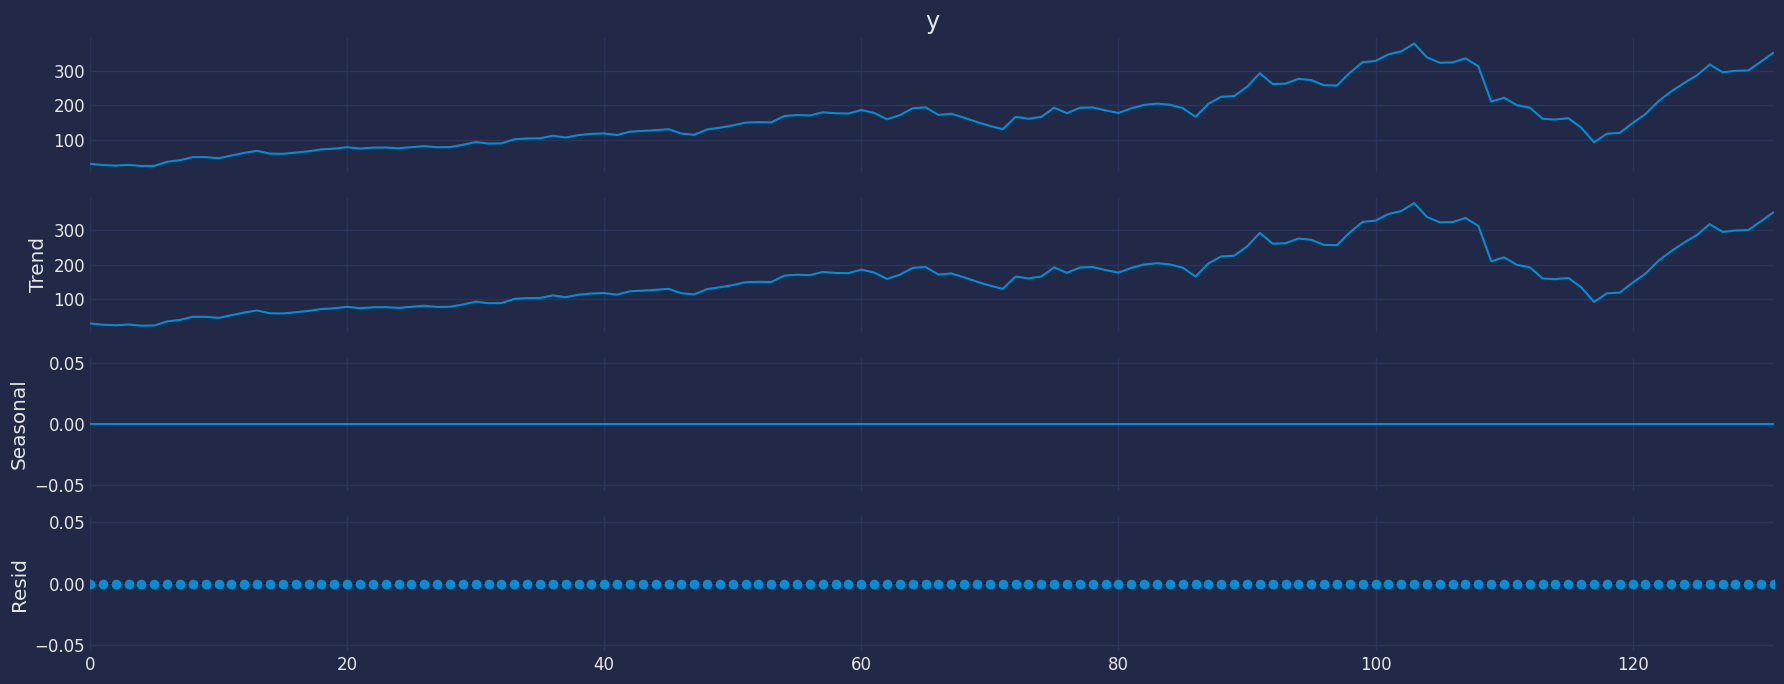

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "add", period=1)
a.plot();


In [39]:
train = df[df.ds<='2021-01-01']
test = df[df.ds>'2021-01-01']

In [40]:
train.shape, test.shape

((97, 4), (35, 4))

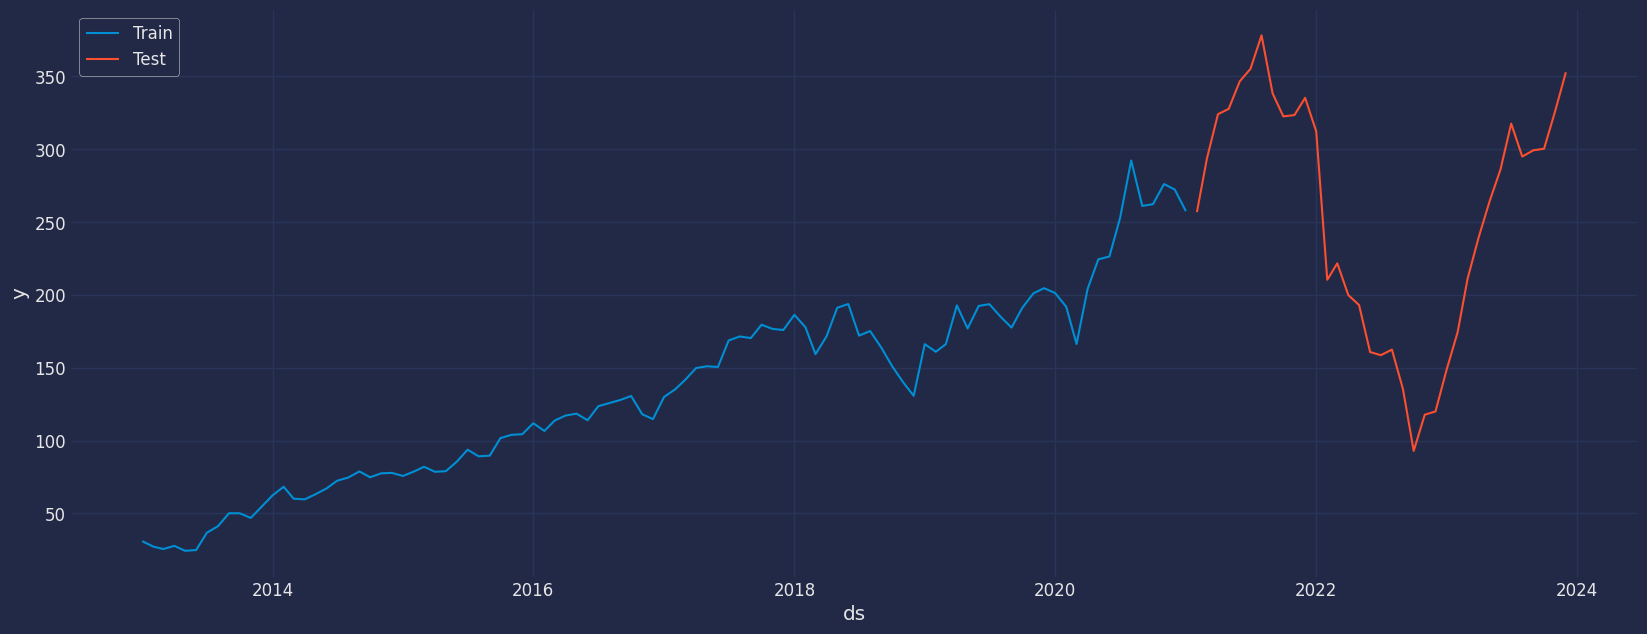

In [41]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

In [42]:
from statsforecast.models import AutoETS

In [43]:
autoets = AutoETS(model=["A","Z","N"],  alias="AutoETS", season_length=1)


In [44]:
autoets = autoets.fit(df["y"].values)
autoets

AutoETS

In [45]:
y_hat_dict = autoets.predict(h=6)
y_hat_dict

{'mean': array([352.89481824, 352.89481824, 352.89481824, 352.89481824,
        352.89481824, 352.89481824])}

In [46]:
forecast=pd.Series(pd.date_range("2021-01-01", freq="ys", periods=6))
forecast=pd.DataFrame(forecast)
forecast.columns=["ds"]
forecast["hat"]=y_hat_dict.get("mean")
forecast["unique_id"]="1"
forecast

<ipython-input-46-c414e12219d1>:1: FutureWarning: 'ys' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast=pd.Series(pd.date_range("2021-01-01", freq="ys", periods=6))


,ds,hat,unique_id
0,2021-01-01,352.894818,1
1,2022-01-01,352.894818,1
2,2023-01-01,352.894818,1
3,2024-01-01,352.894818,1
4,2025-01-01,352.894818,1
5,2026-01-01,352.894818,1


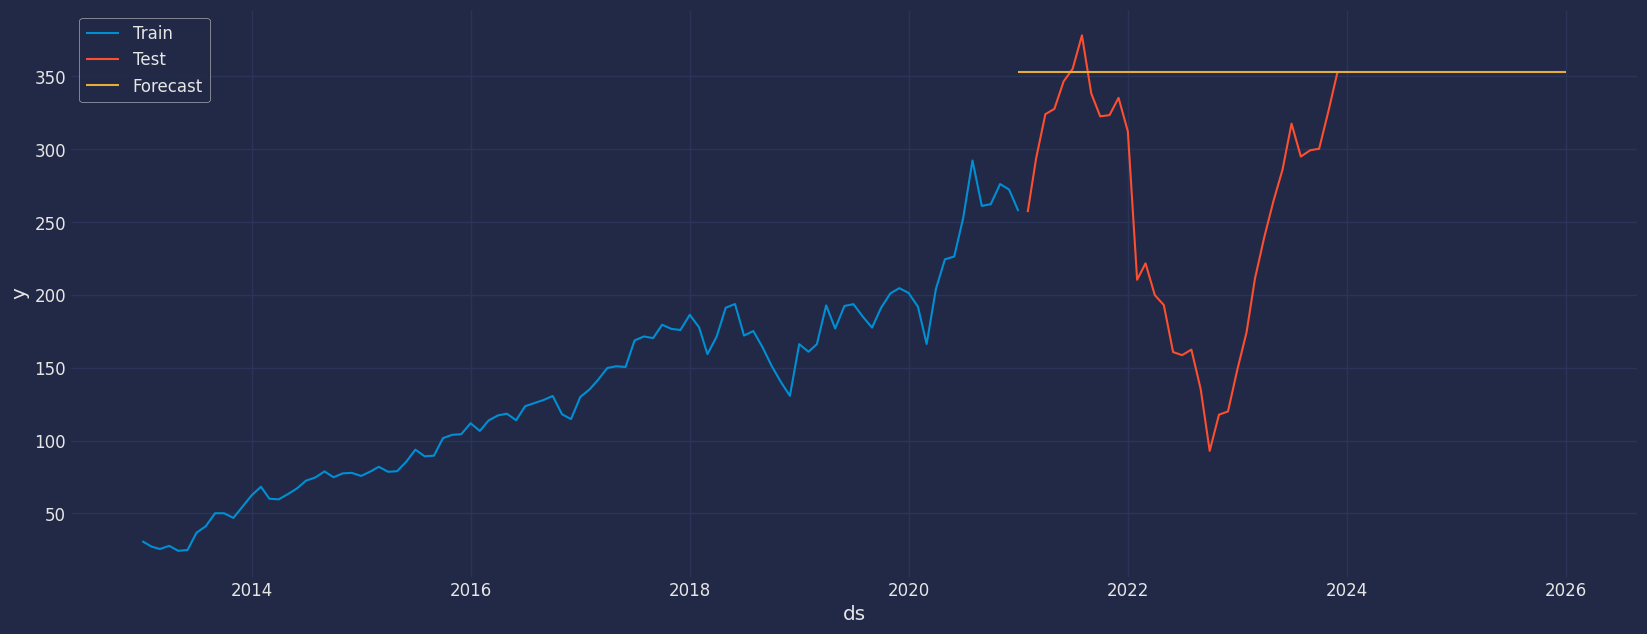

In [47]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
sns.lineplot(forecast,x="ds", y="hat", label="Forecast",)
plt.show()

In [48]:
y_hat_dict = autoets.predict(h=6, level=[80,90,95])
y_hat_dict

{'mean': array([352.89481824, 352.89481824, 352.89481824, 352.89481824,
        352.89481824, 352.89481824]),
 'lo-95': array([317.35574825, 302.63749639, 291.34344698, 281.82200904,
        273.43339923, 265.84948514]),
 'lo-90': array([323.06949051, 310.71754418, 301.23927913, 293.24863652,
        286.20869325, 279.84407191]),
 'lo-80': array([329.65706941, 320.0333218 , 312.64853983, 306.4228062 ,
        300.93778906, 295.97893418]),
 'hi-80': array([376.13256707, 385.75631468, 393.14109665, 399.36683029,
        404.85184742, 409.8107023 ]),
 'hi-90': array([382.72014597, 395.07209231, 404.55035735, 412.54099996,
        419.58094324, 425.94556458]),
 'hi-95': array([388.43388824, 403.1521401 , 414.4461895 , 423.96762744,
        432.35623725, 439.94015134])}

In [49]:
forecast["hat"]=y_hat_dict.get("mean")

forecast["lo-80"]=y_hat_dict.get("lo-80")
forecast["hi-80"]=y_hat_dict.get("hi-80")

forecast["lo-90"]=y_hat_dict.get("lo-80")
forecast["hi-90"]=y_hat_dict.get("hi-80")

forecast["lo-95"]=y_hat_dict.get("lo-95")
forecast["hi-95"]=y_hat_dict.get("hi-95")
forecast

,ds,hat,unique_id,lo-80,hi-80,lo-90,hi-90,lo-95,hi-95
0,2021-01-01,352.894818,1,329.657069,376.132567,329.657069,376.132567,317.355748,388.433888
1,2022-01-01,352.894818,1,320.033322,385.756315,320.033322,385.756315,302.637496,403.152140
2,2023-01-01,352.894818,1,312.648540,393.141097,312.648540,393.141097,291.343447,414.446189
3,2024-01-01,352.894818,1,306.422806,399.366830,306.422806,399.366830,281.822009,423.967627
4,2025-01-01,352.894818,1,300.937789,404.851847,300.937789,404.851847,273.433399,432.356237
5,2026-01-01,352.894818,1,295.978934,409.810702,295.978934,409.810702,265.849485,439.940151


In [50]:
df=df.set_index("ds")
forecast=forecast.set_index("ds")

In [51]:
# Convert index to a series before applying tz_localize
df['ds'] = pd.to_datetime(df.index.to_series()).dt.tz_localize(None)
forecast['ds'] = pd.to_datetime(forecast.index.to_series()).dt.tz_localize(None)

# Now you can perform the merge
df['unique_id'] = df['unique_id'].astype(object)
df_plot = df.merge(forecast, how='left', on=['unique_id', 'ds'])

ValueError: 'ds' is both an index level and a column label, which is ambiguous.

In [ ]:
fig, ax = plt.subplots()
plt.plot_date(df_plot.index, df_plot["y"],label="Actual", linestyle="-")
plt.plot_date(df_plot.index, df_plot["hat"],label="Forecas", linestyle="-")
ax.fill_between(df_plot.index,
                df_plot['lo-80'],
                df_plot['hi-80'],
                alpha=.35,
                color='orange',
                label='AutoETS-level-95')
ax.set_title('', fontsize=22)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=12)
plt.legend(fontsize=12)
ax.grid(True)

plt.show()

In [ ]:
autoets.predict_in_sample()

In [ ]:
autoets.forecast(y=train["y"].values, h=6, fitted=True)


In [ ]:
autoets.forecast(y=train["y"].values, h=6, fitted=True, level=[95])


In [ ]:
autoets.forward(train["y"].values, h=6)



In [ ]:
from sklearn import metrics

In [ ]:
def model_evaluation(y_true, y_pred, model):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print (f'Model Evaluation: {model}')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}')
    print(f'corr is : {np.corrcoef(y_true, y_pred)[0,1]}',end='\n\n')


In [ ]:
model_evaluation(test["y"], forecast["hat"], "AutoETS")



# **ETS IPC**

In [52]:
ticker = yf.Tickers(["LABB.MX", "VESTA.MX", "ORBIA.MX", "GFNORTEO.MX", "BBAJIOO.MX", "MEGACPO.MX",
                     "AC.MX", "GCC.MX", "GENTERA.MX", "CUERVO.MX", "AMXB.MX", "GCARSOA1.MX",
                     "KIMBERA.MX", "GMEXICOB.MX", "CHDRAUIB.MX", "GRUMAB.MX", "KOFUBL.MX",
                     "RA.MX", "BOLSAA.MX", "ALSEA.MX", "TLEVISACPO.MX", "Q.MX", "BIMBOA.MX",
                     "PINFRA.MX", "GAPB.MX", "ASURB.MX", "OMAB.MX", "CEMEXCPO.MX"])
data = ticker.history(start= '2015-01-01', end= '2023-12-31', interval='1mo')['Close']
# Fecha en meses
data.head()

[*********************100%***********************]  28 of 28 completed


Ticker,AC.MX,ALSEA.MX,AMXB.MX,ASURB.MX,BBAJIOO.MX,BIMBOA.MX,BOLSAA.MX,CEMEXCPO.MX,CHDRAUIB.MX,CUERVO.MX,...,KOFUBL.MX,LABB.MX,MEGACPO.MX,OMAB.MX,ORBIA.MX,PINFRA.MX,Q.MX,RA.MX,TLEVISACPO.MX,VESTA.MX
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,65.702614,37.795330,11.671398,154.705292,NaN,34.200211,15.430020,11.531770,37.656044,NaN,...,NaN,19.345697,38.958511,38.346149,33.284695,130.751801,NaN,56.302017,88.730598,23.547867
2015-02-01 00:00:00+00:00,70.285477,43.193314,11.671398,161.849289,NaN,37.858761,16.780149,13.125944,44.382282,NaN,...,NaN,13.299150,39.022583,39.573223,34.902489,138.726166,NaN,57.645119,92.414062,23.328478
2015-03-01 00:00:00+00:00,69.477173,42.006325,11.124300,162.236130,NaN,38.791328,16.133083,12.536795,41.835014,NaN,...,NaN,11.775288,42.517673,41.436157,32.001625,126.094261,NaN,56.418171,91.677383,23.035957
2015-04-01 00:00:00+00:00,69.892464,43.400570,11.737050,171.416763,NaN,36.944118,18.360481,13.335611,41.735294,NaN,...,NaN,14.749671,45.450417,42.735741,35.294964,136.695740,NaN,63.874294,101.554535,23.328478
2015-05-01 00:00:00+00:00,70.519684,43.626663,11.744344,179.291840,NaN,37.374535,16.991690,12.993212,42.756985,NaN,...,NaN,13.535471,46.048355,40.197922,37.479794,130.000046,NaN,61.689011,105.901932,22.910898


In [53]:
# Re programar el formato de la fecha
data.index = data.index.strftime('%Y-%m')
data.index = pd.to_datetime(data.index)

In [54]:
# De columnas las convierte en filas des-pivot (todo en forma vertical), para poder usar más adelante la paqueteria
data = data.melt(ignore_index=False)


In [56]:
data.head()

,Ticker,value
Date,,
2015-01-01,AC.MX,65.702614
2015-02-01,AC.MX,70.285477
2015-03-01,AC.MX,69.477173
2015-04-01,AC.MX,69.892464
2015-05-01,AC.MX,70.519684


In [55]:
df = pd.DataFrame({"ds": data.index,
                   "y": data['value'],
                   "unique_id": data['Ticker']})
df.reset_index(drop=True, inplace=True) # Para quitar el indice de lo que acabamos de crear


In [57]:
df.head() # Renombrando las columnas

,ds,y,unique_id
0,2015-01-01,65.702614,AC.MX
1,2015-02-01,70.285477,AC.MX
2,2015-03-01,69.477173,AC.MX
3,2015-04-01,69.892464,AC.MX
4,2015-05-01,70.519684,AC.MX


In [59]:
# Limpiar valores (NAs - sin valores, limpiar data para poder pronosticar)
df.dropna(inplace=True)

In [60]:
train = df[df.ds<'2023-01-01']
test = df[df.ds>='2023-01-01']

In [61]:
df.head()

,ds,y,unique_id
0,2015-01-01,65.702614,AC.MX
1,2015-02-01,70.285477,AC.MX
2,2015-03-01,69.477173,AC.MX
3,2015-04-01,69.892464,AC.MX
4,2015-05-01,70.519684,AC.MX


In [64]:
train.shape, test.shape

((2573, 3), (336, 3))

In [67]:
season_length = 12 # Datos mensuales
horizon = len(test['ds'].unique()) # Datos a predecir

models = [AutoETS(season_length=season_length, model='ZZZ')] # ZZZ es no se nada para que la misma libreria

In [68]:
sf = StatsForecast(df=train,
                   models=models,
                   freq='MS',
                   n_jobs=-1)


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [69]:
sf.fit()

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


StatsForecast(models=[AutoETS])

In [70]:
sf.fitted[0,0].model_.keys()

# encontrar cuales son los modelos que se ajustan peor

AttributeError: 'StatsForecast' object has no attribute 'fitted'